# Assignment 2

## Task 1 Monthly and annual mean wind speeds (20 Years)

In [17]:
import xarray as xr
import numpy as np
import salem 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask.array as da
import pandas as pd
from functools import partial
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#pip install --upgrade tabulate
from IPython.display import display, Markdown

In [18]:
#create month list 
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#create location dict with lat and lon information 
dict_location_lat_lon = {
    "Le Bons Bay": {"lat":-43.7411 , "lon":173.0919 },
     "Kaikoura": {"lat":-42.3994 , "lon":173.6799 },
     "Lyttelton Harbour": {"lat":-43.6033 , "lon":172.7227 },
     "Christchurch": {"lat":-43.5320 , "lon":172.6306 },
    "Lake Tekapo": {"lat":-43.9090 , "lon":170.5219 },
    "Darfield": {"lat":-43.4896 , "lon":172.1097 },
    "Rangiora": {"lat":-43.3032 , "lon":172.5966 },
    "Pukaki Aerodrome": {"lat":-44.2376 , "lon":170.1185 },
    "Winchmore": {"lat":-43.8091 , "lon":171.6944 },
    "Fairlie": {"lat":-44.0977 , "lon":170.8289 },
    "Mt Cook Village": {"lat":-43.7343 , "lon":170.0962 },
    "Timaru": {"lat":-44.3904 , "lon":171.2373 },
    "Culverden": {"lat":-42.7726 , "lon":172.8493 },
    "Hanmer Springs": {"lat":-42.5256 , "lon":172.8289 }
}

In [19]:
#creates a Pandas DataFrame named df from the dictionary dict_location_lat_lon, and column name is months
df = pd.DataFrame(data =dict_location_lat_lon, columns = month_list, index = dict_location_lat_lon)
df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#month:
from functools import partial

def _preprocess(x, lon_bnds, lat_bnds):
    """This defines a function named _preprocess that takes three arguments: x, lon_bnds, and lat_bnds. This function uses the xarray library to slice a dataset x along the longitude and latitude dimensions based on the lon_bnds and lat_bnds tuples."""
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))

def cal_avg_ws(height = 10, month = 1):
    """calculates the average wind speed for a given height and month. """
    lon_bnds, lat_bnds = (170, 175), (-46, -40)
    partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
    
    #load data for U
    ds_u = xr.open_mfdataset("/mnt/data/MetService_WRF/U_*{:02d}01000000.nc".format(month), preprocess=partial_func, chunks={"time":72,"height":1}, parallel=True)
    #select where height is 10
    ds_u_sel = ds_u.U.sel(height = height)
    #Quadratic power of U value
    squared_U = ds_u_sel**2
    
    #load data for V
    ds_v = xr.open_mfdataset("/mnt/data/MetService_WRF/V_*{:02d}01000000.nc".format(month), preprocess=partial_func, chunks={"time":72,"height":1}, parallel=True)
    #select where height is 10
    ds_v_sel = ds_v.V.sel(height = height)
    #Quadratic power of V value
    squared_V = ds_v_sel**2
    
    #calculate wind speed
    ws = np.sqrt(squared_U + squared_V)
    #calculate the mean
    ws_monthly = ws.mean(dim='time')
    
    return ws_monthly.compute()

In [21]:
%%time
#what the df looks like at the very beginning: 
print("Dataframe at the beginning: ")
print(df)

#loop each month, there will be 12 loops
for i, month in enumerate(month_list):
    print("The calculation function is running for the month of:"+ str(month))
    with ProgressBar():
        #the function named cal_avg_ws is called to calculate mean for all cities by month
        data = cal_avg_ws(month=i+1, height=10)
    #since we have value for all cities for one month, what we do next is to select the value based on the lon and lat 
    for city in df.index:
        lat = dict_location_lat_lon[city]["lat"]
        lon = dict_location_lat_lon[city]["lon"]
        #select result based on lat and lon of the city 
        sel_result = data.sel(lat = lat, lon = lon, method = "nearest")
        #put the selected value to specifc city and month 
        df.loc[city, month] = np.round(sel_result.data,decimals = 1)
    # define the title as a Markdown string
    title = 'Table 1. Mean monthly and annual wind speed (m/s)\n'
    # display the title and the dataframe using IPython.display
    display(Markdown(title))
    display(df)
#what the df looks like at the end: 
print("Dataframe at the end: ")
display(Markdown(title))
display(df)  

Dataframe at the beginning: 
                   Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
Le Bons Bay        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Kaikoura           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Lyttelton Harbour  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Christchurch       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Lake Tekapo        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Darfield           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Rangiora           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Pukaki Aerodrome   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Winchmore          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Fairlie            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Mt Cook Village    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Timaru             NaN  NaN  NaN  N

Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Feb
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  1min 32.2s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Mar
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 42.7s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Apr
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1min 37.4s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:May
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1min 38.5s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Jun
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 36.3s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,NaN,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,NaN,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,NaN,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,NaN,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,NaN,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,NaN,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,NaN,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Jul
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1min 37.5s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,NaN,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,NaN,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,NaN,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,NaN,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,NaN,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,NaN,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,NaN,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,NaN,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,NaN,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Aug
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1min 38.0s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,NaN,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,NaN,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,NaN,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,NaN,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,NaN,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,NaN,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,NaN,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,NaN,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,NaN,NaN,NaN,NaN


The calculation function is running for the month of:Sep
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1min 32.7s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,4.3,NaN,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,2.9,NaN,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,3.4,NaN,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,2.7,NaN,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,4.5,NaN,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,4.4,NaN,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,3.5,NaN,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,2.4,NaN,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,3.1,NaN,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,2.7,NaN,NaN,NaN


The calculation function is running for the month of:Oct
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 39.7s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,4.3,4.4,NaN,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,2.9,3.0,NaN,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,3.4,3.8,NaN,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,2.7,3.0,NaN,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,4.5,4.5,NaN,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,4.4,4.4,NaN,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,3.5,3.7,NaN,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,2.4,2.6,NaN,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,3.1,3.2,NaN,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,2.7,2.9,NaN,NaN


The calculation function is running for the month of:Nov
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1min 36.5s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,4.3,4.4,4.3,NaN
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,2.9,3.0,3.0,NaN
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,3.4,3.8,3.9,NaN
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,2.7,3.0,3.1,NaN
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,4.5,4.5,4.5,NaN
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,4.4,4.4,4.3,NaN
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,3.5,3.7,3.8,NaN
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,2.4,2.6,2.8,NaN
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,3.1,3.2,3.2,NaN
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,2.7,2.9,3.0,NaN


The calculation function is running for the month of:Dec
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1min 36.8s


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,4.3,4.4,4.3,4.3
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,2.9,3.0,3.0,2.9
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,3.4,3.8,3.9,4.1
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,2.7,3.0,3.1,3.2
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,4.5,4.5,4.5,4.3
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,4.4,4.4,4.3,4.3
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,3.5,3.7,3.8,3.8
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,2.4,2.6,2.8,2.7
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,3.1,3.2,3.2,3.2
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,2.7,2.9,3.0,2.8


Dataframe at the end: 


Table 1. Mean monthly and annual wind speed (m/s)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Le Bons Bay,4.3,4.2,4.1,3.9,4.1,4.2,4.1,4.0,4.3,4.4,4.3,4.3
Kaikoura,3.0,2.8,2.7,2.5,2.7,2.8,2.8,2.6,2.9,3.0,3.0,2.9
Lyttelton Harbour,4.1,3.9,3.7,3.3,3.3,3.2,3.1,3.2,3.4,3.8,3.9,4.1
Christchurch,3.2,2.9,2.7,2.3,2.2,2.1,2.1,2.2,2.7,3.0,3.1,3.2
Lake Tekapo,4.3,3.8,3.5,3.3,3.7,3.5,3.4,3.4,4.5,4.5,4.5,4.3
Darfield,4.4,4.2,4.1,3.7,3.9,3.8,3.8,3.8,4.4,4.4,4.3,4.3
Rangiora,3.9,3.5,3.3,2.9,3.0,3.0,3.0,3.0,3.5,3.7,3.8,3.8
Pukaki Aerodrome,2.7,2.3,2.1,1.9,2.0,1.8,1.8,1.7,2.4,2.6,2.8,2.7
Winchmore,3.2,2.9,2.7,2.6,2.7,2.7,2.7,2.7,3.1,3.2,3.2,3.2
Fairlie,2.9,2.5,2.4,2.2,2.3,2.3,2.3,2.2,2.7,2.9,3.0,2.8


CPU times: user 4min 27s, sys: 5min 11s, total: 9min 38s
Wall time: 19min 45s


## Task 2 Violin plots (20 Years)

In [1]:
import xarray as xr
import numpy as np 
import salem 
import cartopy.crs as ccrs 
import glob 
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask.array as da
import pandas as pd
from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#create month list 
hour_list = []
for i in range(0, 24):
    hour_list.append(i)
    
#create location dict with lat and lon information 
dict_location_lat_lon = {
    "Le Bons Bay": {"lat":-43.7411 , "lon":173.0919 },
     "Kaikoura": {"lat":-42.3994 , "lon":173.6799 },
     "Lyttelton Harbour": {"lat":-43.6033 , "lon":172.7227 },
     "Christchurch": {"lat":-43.5320 , "lon":172.6306 },
    "Lake Tekapo": {"lat":-43.9090 , "lon":170.5219 },
    "Darfield": {"lat":-43.4896 , "lon":172.1097 },
    "Rangiora": {"lat":-43.3032 , "lon":172.5966 },
    "Pukaki Aerodrome": {"lat":-44.2376 , "lon":170.1185 },
    "Winchmore": {"lat":-43.8091 , "lon":171.6944 },
    "Fairlie": {"lat":-44.0977 , "lon":170.8289 },
    "Mt Cook Village": {"lat":-43.7343 , "lon":170.0962 },
    "Timaru": {"lat":-44.3904 , "lon":171.2373 },
    "Culverden": {"lat":-42.7726 , "lon":172.8493 },
    "Hanmer Springs": {"lat":-42.5256 , "lon":172.8289 }
}

In [3]:
def _preprocess(x, lon, lat, height):
    """preprocess the data based on a given height, latitude and longitude"""
    return x.sel(height = height, lon=lon, lat=lat, method = "nearest")

def group_by_hours(height = 10, lat = -43.7411, lon = 173.0919):
    """to group the wind speed data by hour, based on a given height, latitude and longitude"""
    # Create a partial function of _preprocess to set the specific longitude, latitude and height parameters
    partial_func = partial(_preprocess, lon=lon, lat=lat, height = height)
    
    # Load the U-component wind data from multiple netCDF files using the xarray library and preprocess it with the partial_func
    ds_U = xr.open_mfdataset("/mnt/data/MetService_WRF/U_*.nc", preprocess=partial_func, chunks={"time": 500, "height":1}, parallel=True)
    U = ds_U.U
    
    # Load the V-component wind data from multiple netCDF files using the xarray library and preprocess it with the partial_func
    ds_V = xr.open_mfdataset("/mnt/data/MetService_WRF/V_*.nc", preprocess=partial_func, chunks={"time": 500, "height":1}, parallel=True)
    V = ds_V.V
    
    # Calculate the wind speed from the U and V components and compute the data
    ws = np.sqrt(U**2 + V**2).compute()
    
    # Group the wind speed data by hour
    ws_grouped_data = ws.groupby("time.hour")

    return ws_grouped_data

In [4]:
def plot_voilin(dict_location_lat_lon, height=10):
    """defines a function called plot_voilin that takes two arguments: dict_location_lat_lon, which is a dictionary that contains the latitude and longitude coordinates of each city, and height, which is the height at which to calculate the wind speed (default is 10 meters)."""
    #loop each city from the city list
    for city in dict_location_lat_lon:
        # for each city, calculate the mean wind speed and group by hour
        ws_grouped_data = group_by_hours(lat=dict_location_lat_lon[city]["lat"], lon=dict_location_lat_lon[city]["lon"], height = 10)
        
        #split each hour and make a new list for each 
        data_list = []
        for i in hour_list:
            data_list.append(list(ws_grouped_data[i]))
            
        # plot the violin plot for each city
        fig, ax = plt.subplots(figsize=(25, 9))
        sns.violinplot(data=data_list, palette="husl", inner="box", showmedians= True)
        ax.set_title("Violin Plot - {}".format(city), fontsize=20)
        ax.set_xlabel("Hour", fontsize=16)
        ax.set_ylabel("Wind Speed(m/s)", fontsize=16)
        fig.patch.set_facecolor('#EAEAF2')
        plt.show()

[########################################] | 100% Completed | 36.8s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed |  1hr 28min 39.5s


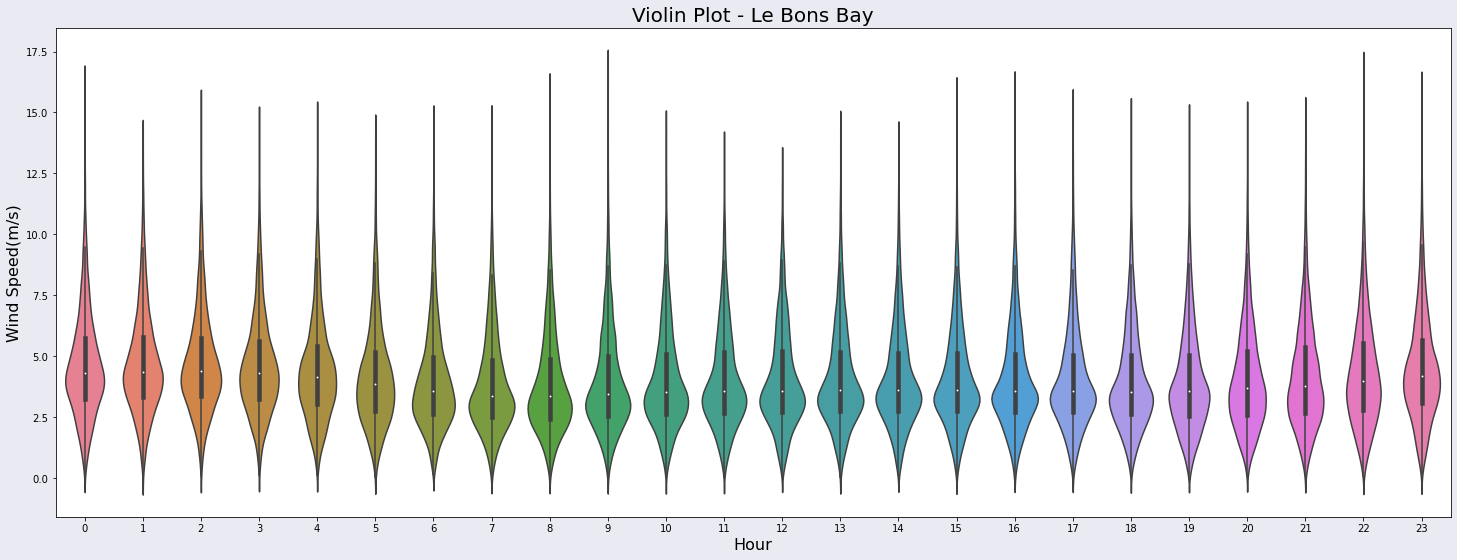

[########################################] | 100% Completed | 16.0s
[########################################] | 100% Completed | 15.6s
[########################################] | 100% Completed | 44min 35.2s


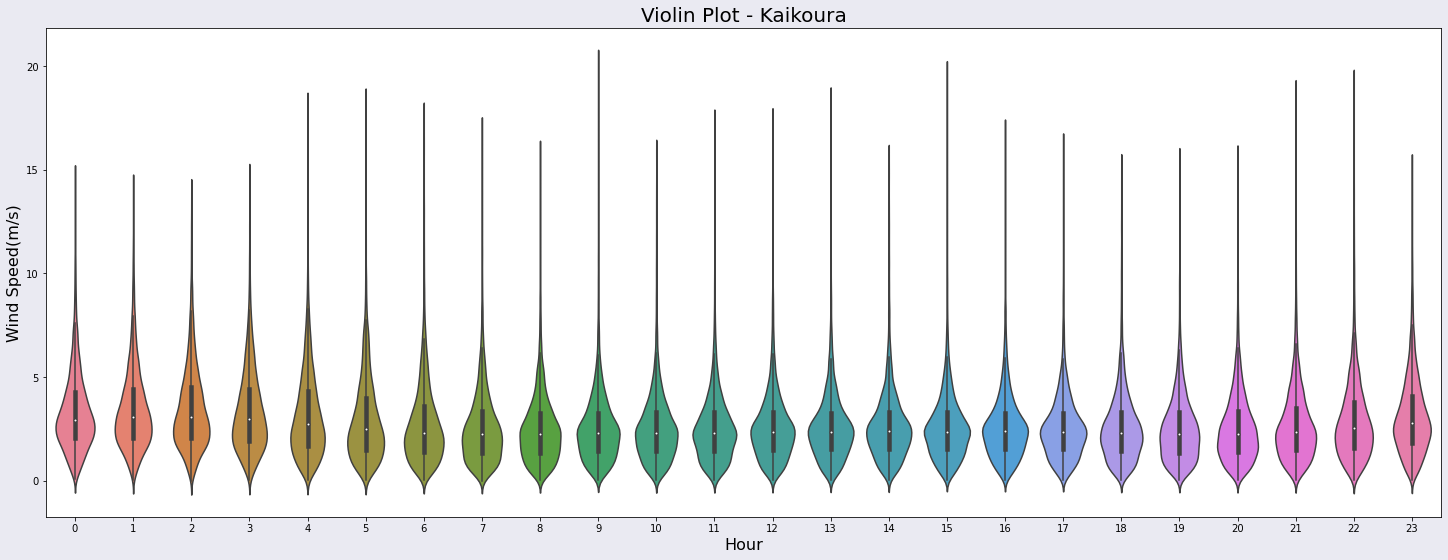

[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed | 35min  8.6s


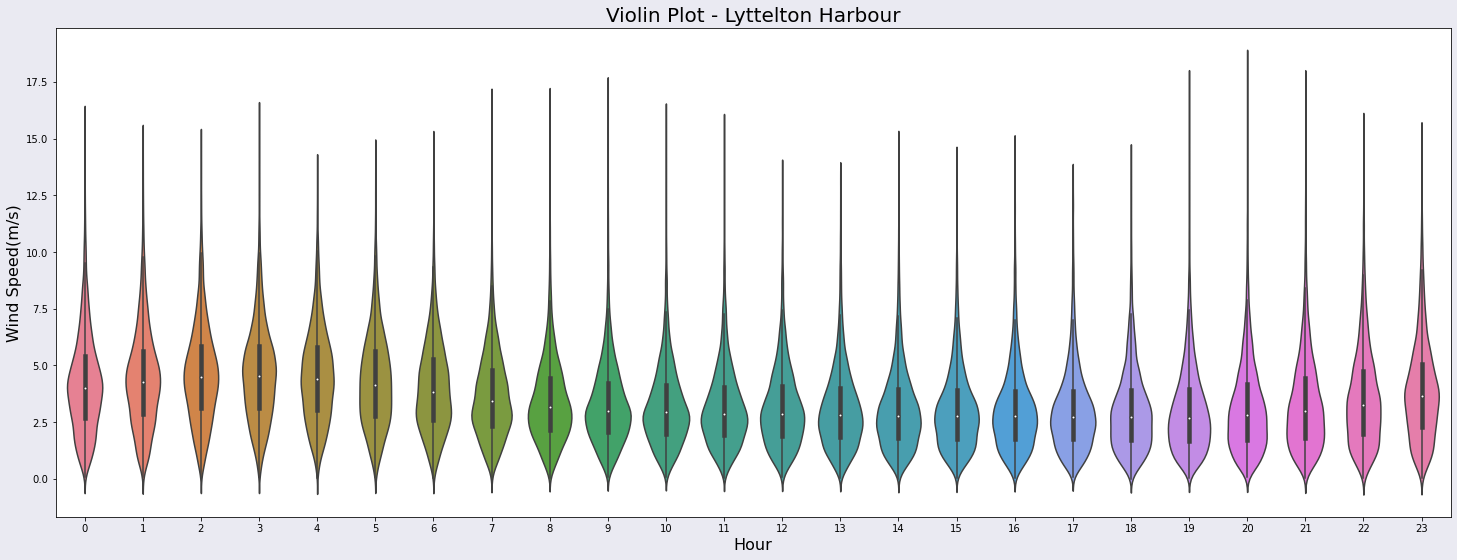

[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed | 31min 22.7s


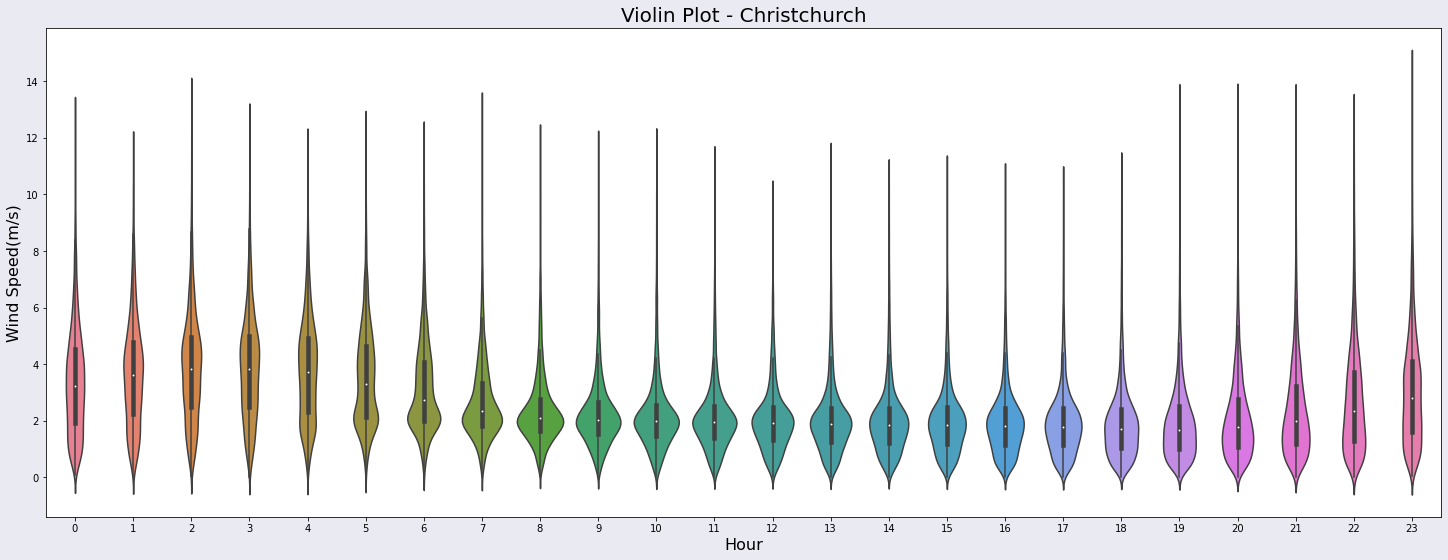

[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed | 15min  1.6s


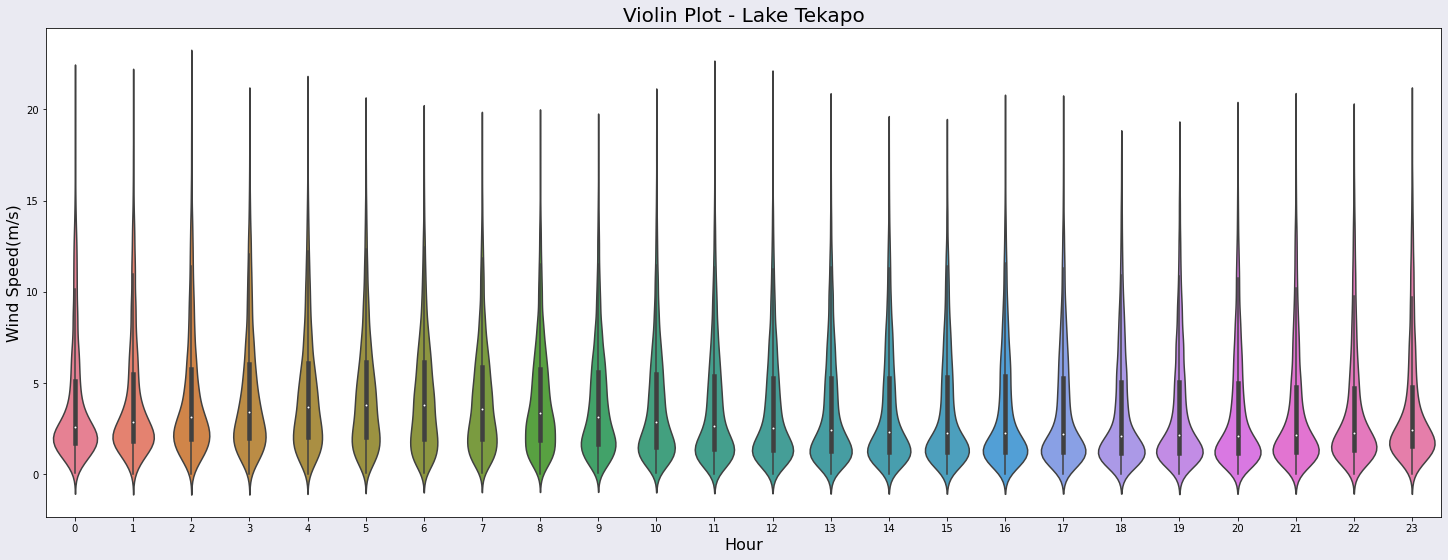

[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed | 19min 28.5s


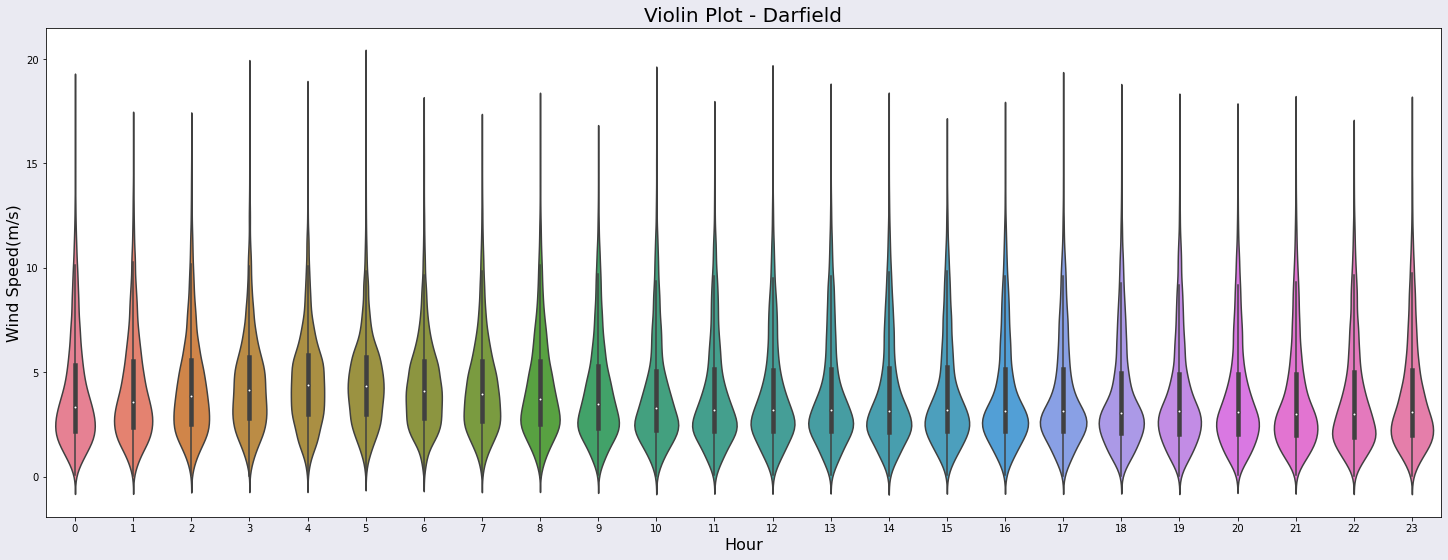

[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed | 50min 56.7s


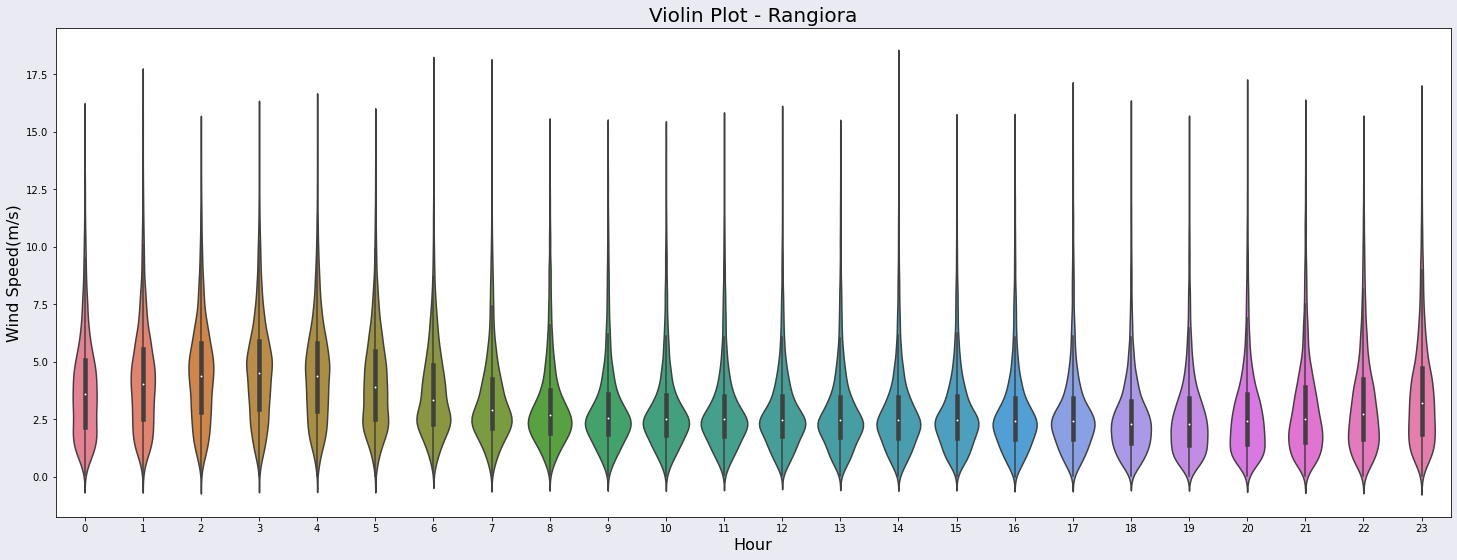

[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed | 51min 35.0s


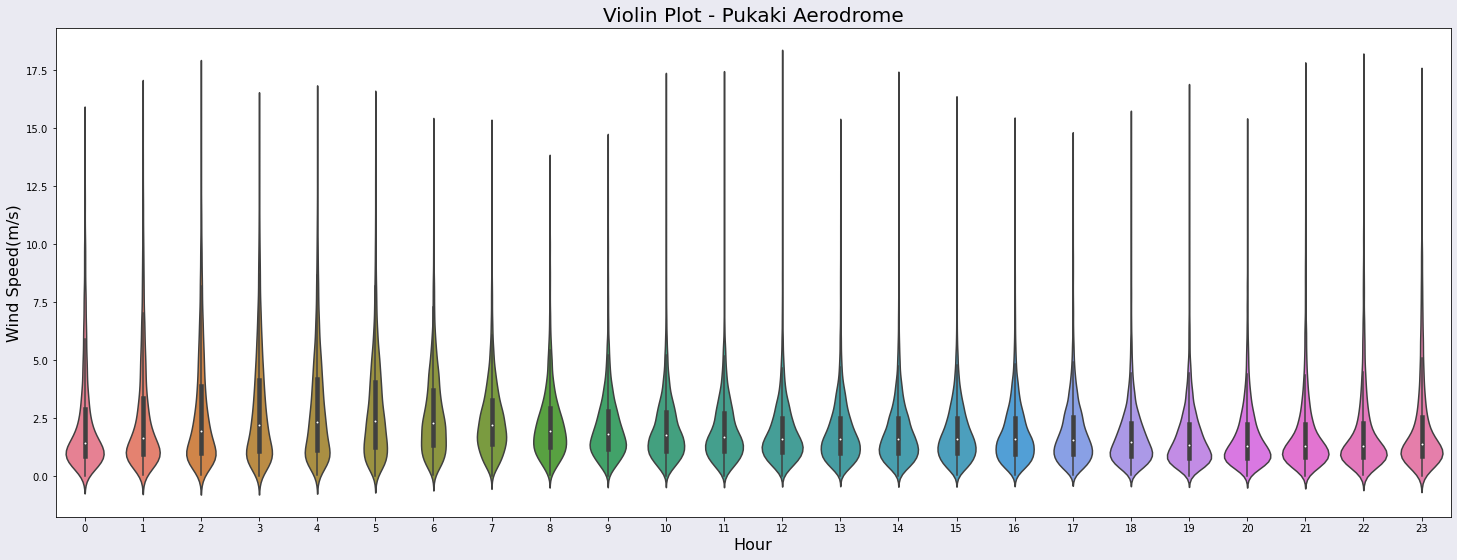

[########################################] | 100% Completed |  1min 15.8s
[########################################] | 100% Completed |  1min  4.8s
[########################################] | 100% Completed | 37min 13.5s


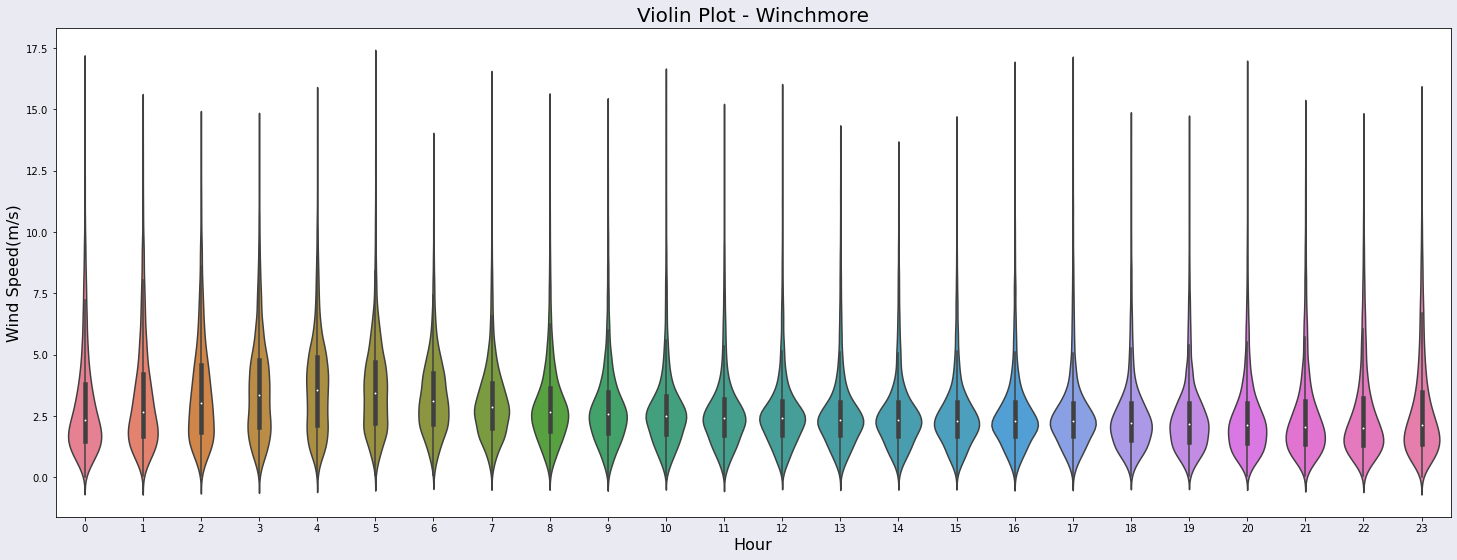

[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 16.8s
[########################################] | 100% Completed | 26min 39.3s


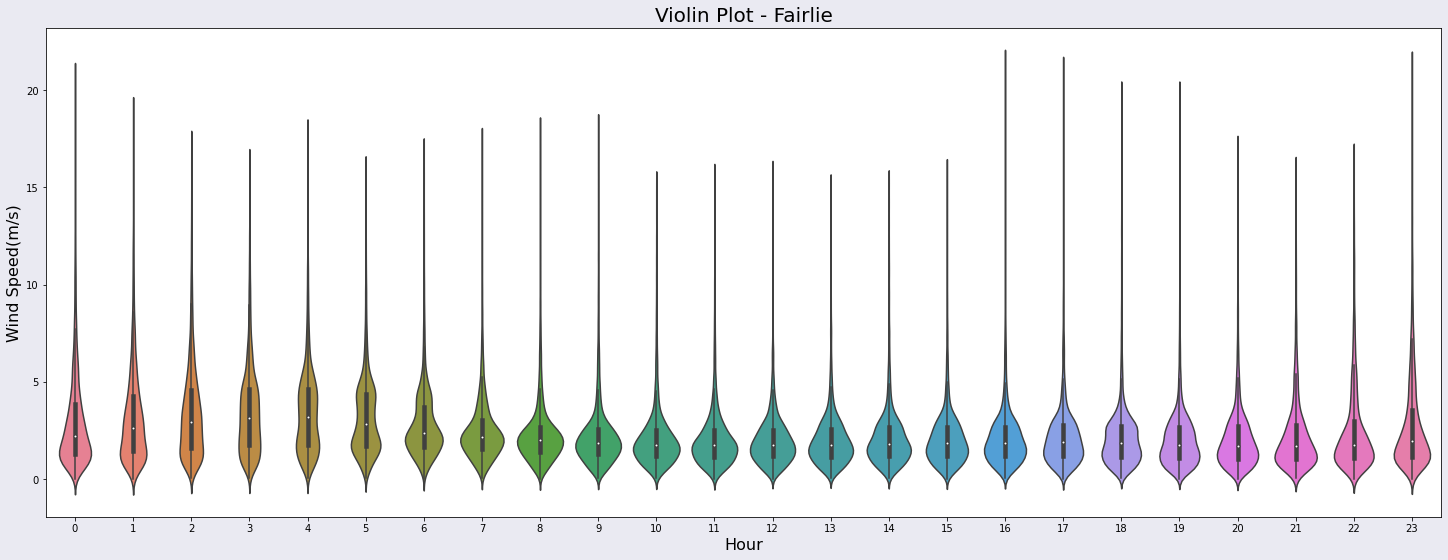

[########################################] | 100% Completed | 15.5s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 34min 51.6s


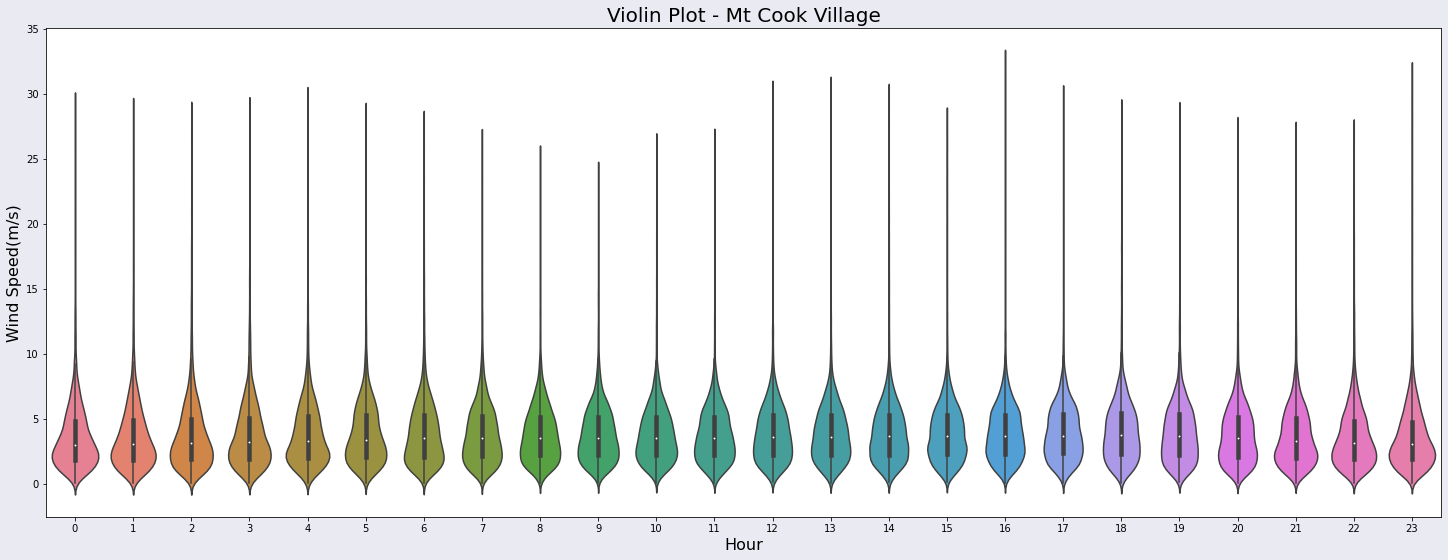

[########################################] | 100% Completed |  1min 13.0s
[########################################] | 100% Completed | 53.7s
[########################################] | 100% Completed | 44min 12.1s


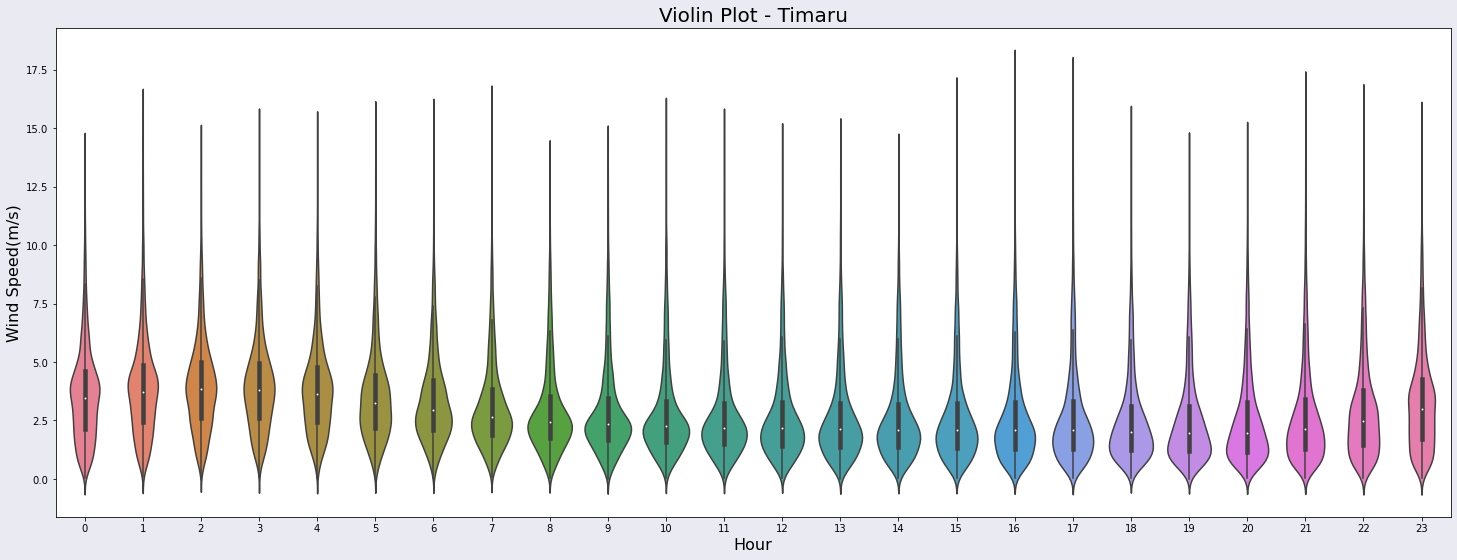

[########################################] | 100% Completed |  3min 13.8s
[########################################] | 100% Completed |  3min 48.9s
[########################################] | 100% Completed | 34min 18.3s


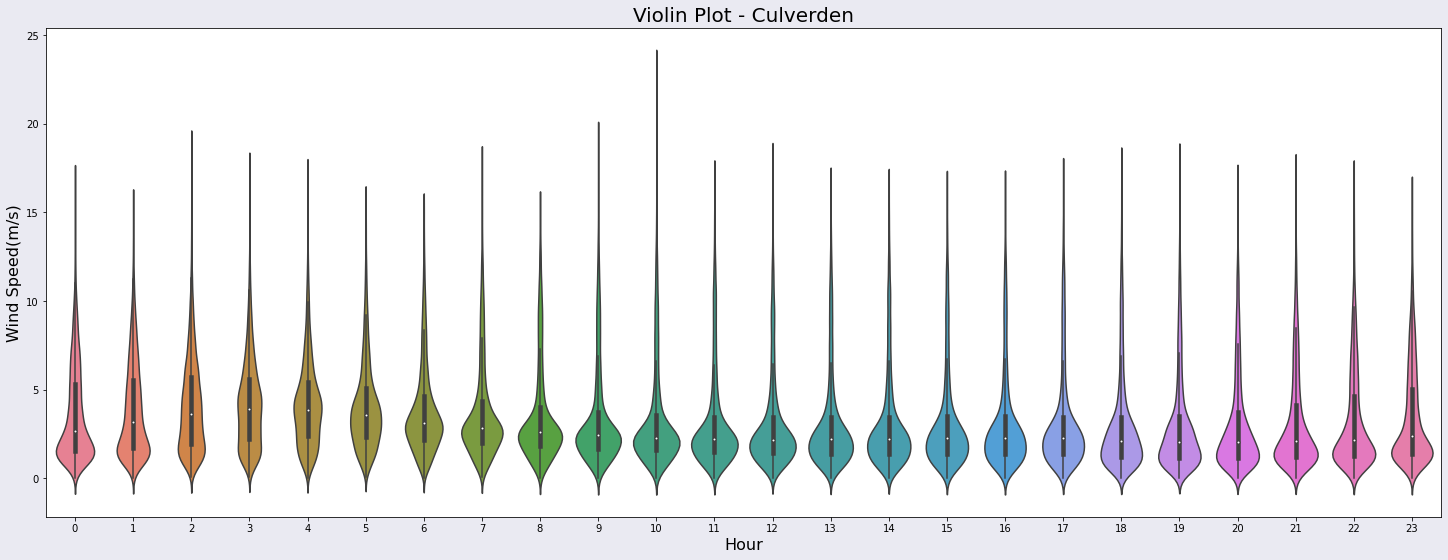

[########################################] | 100% Completed | 25.9s
[########################################] | 100% Completed | 22.0s
[########################################] | 100% Completed | 28min 56.4s


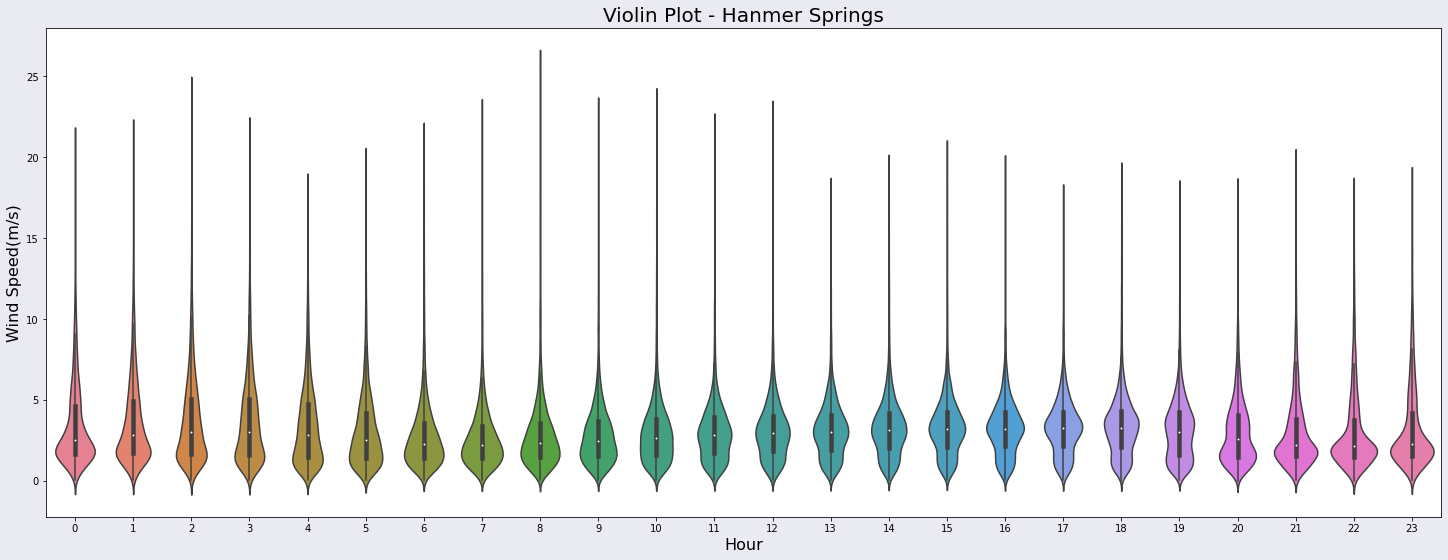

CPU times: user 58min 2s, sys: 50min 58s, total: 1h 49min 1s
Wall time: 9h 25min 35s


In [5]:
%%time 
with ProgressBar():
    #call plot_voilin function
    plot_voilin(dict_location_lat_lon, height = 10)

## Task 3 Median annual average temperature (20 Years)

In [1]:
import xarray as xr
import numpy as np
import salem
import cartopy.crs as ccrs
import glob
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask.array as da
import pandas as pd
from functools import partial
import seaborn as sns
import cartopy.feature as cfeature
import cartopy as cart
import matplotlib.ticker as mticker

In [2]:
def _preprocess(x, height):
    """This defines a function named _preprocess that takes three arguments: x, lon_bnds, and lat_bnds. This function uses the xarray library to slice a dataset x along the longitude and latitude dimensions based on the lon_bnds and lat_bnds tuples."""
    return x.sel(height = height)

def median_yearly_T_mean(height = 20):
    """calculates the median annual average temperature for the height of 20 """
    
    # Create a partial function with _preprocess and set the height value to the given value or 20 if not provided
    partial_func = partial(_preprocess, height = height)
    
    # Load multiple NetCDF files as a single xarray dataset, using the preprocess function partial_func to slice along the height dimension
    ds_T = xr.open_mfdataset("/mnt/data/MetService_WRF/T*.nc", preprocess=partial_func, chunks={"time": 550, "height":1}, parallel=True)
    
    # Select the Temperature variable (T) from the xarray dataset ds_T
    T = ds_T.T
    
    # Group the Temperature data by year using the "year" coordinate
    year_grouped_T = T.groupby("time.year")
    
    # Calculate the mean of the Temperature data along the time dimension, resulting in yearly mean Temperature
    yearly_T_mean = year_grouped_T.mean(dim = "time")
    
    # Calculate the median of the yearly mean Temperature data along the year dimension, and subtract 273 to convert from Kelvin to Celsius
    median_annual_average_tem = yearly_T_mean.median(dim="year")-273
    
    # Compute the final result and return it
    return median_annual_average_tem.compute()

In [3]:
with ProgressBar():
    #This calls the median_yearly_T_mean() function with an argument height of 20, and assigns the result to the variable median_annual_average_tem.
    median_annual_average_tem = median_yearly_T_mean(height = 20)
median_annual_average_tem

[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed |  3hr  8min 37.4s


<xarray.DataArray 'T' (lat: 508, lon: 472)>
array([[10.2258   , 10.230286 , 10.234497 , ...,  9.141541 ,  9.14032  ,
         9.139008 ],
       [10.243469 , 10.24823  , 10.252747 , ...,  9.156464 ,  9.154785 ,
         9.153168 ],
       [10.2612915, 10.266205 , 10.270905 , ...,  9.171326 ,  9.169159 ,
         9.167023 ],
       ...,
       [17.729004 , 17.72583  , 17.722351 , ..., 17.439362 , 17.438324 ,
        17.437073 ],
       [17.74646  , 17.743195 , 17.739777 , ..., 17.453644 , 17.452454 ,
        17.45108  ],
       [17.763672 , 17.760223 , 17.756287 , ..., 17.46753  , 17.466522 ,
        17.465393 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
    height   float64 20.0

In [4]:
def Projection_plt(Canterbury = True, data = median_annual_average_tem):
    
    #Define a projection for this map
    map_proj = ccrs.PlateCarree()
    plt.figure(figsize=(15, 15))
    ax = plt.axes(projection=map_proj)
    
    # Add ocean areas
    ax.add_feature(cart.OCEAN, zorder=2, edgecolor='grey', facecolor='white')
    
    if Canterbury == True:
        #Zoom in to Canterbury region
        ax.set_extent([168.8, 174, -41.5, -45.3])
    else:
        #Zoom in to the specific region
        ax.set_extent([164, 179, -34, -48])

    
    # set the aspect ratio of the map to "equal"
    ax.set_aspect('equal')
    
    # add the coastline feature to the map with adaptive scaling
    ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='none', linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='grey', facecolor='white')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.4)
    
    # Draw spatial gridlines
    gls = ax.gridlines(draw_labels=True, color='white', alpha=0.2, linestyle='--')
    # change the spacing of the gridlines to every 5 degrees of longitude and latitude
    gls.xlocator = plt.FixedLocator(range(-180, 181, 1))
    gls.ylocator = plt.FixedLocator(range(-90, 91, 1))
    
    # change the font size and weight of the labels
    gls.xlabel_style = {'size': 15, 'weight': 'bold'}
    gls.ylabel_style = {'size': 15, 'weight': 'bold'}
    
    
    # hide the labels on the top and right edges of the map
    gls.top_labels = False
    gls.right_labels = False
    
    data = median_annual_average_tem
    
    # Plot the temperature data
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1.5, vmax=18, cmap="turbo")
    
    # Add a colorbar
    fig = plt.gcf()
    fig.set_dpi(80)
    
    #Add a title
    if Canterbury == True:
        plt.title('Canterbury Median Annual Average Temperature', fontsize=20)
    else:
        plt.title('New Zealand Median Annual Average Temperature', fontsize=20)
    
    plt.show()
    

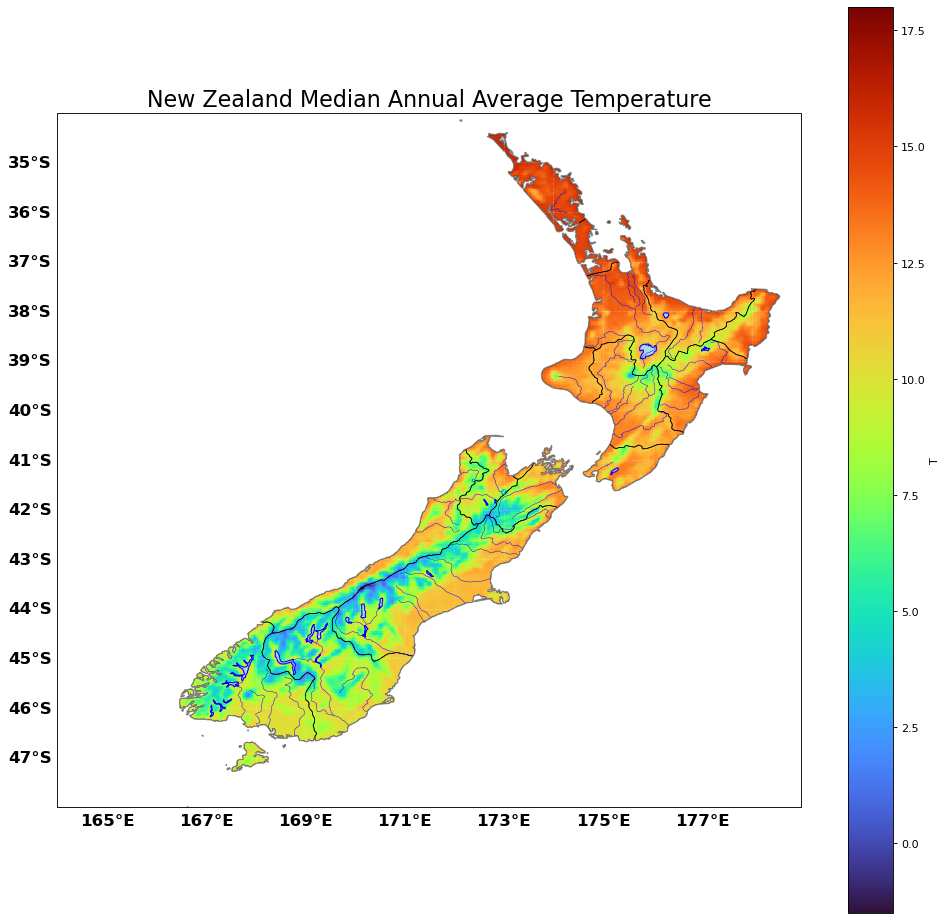

In [10]:
#calls the function Projection_plt() with the arguments Canterbury = False and data = median_annual_average_tem and produces a map of New Zealand's median annual average temperature.
Projection_plt(Canterbury = False, data = median_annual_average_tem)

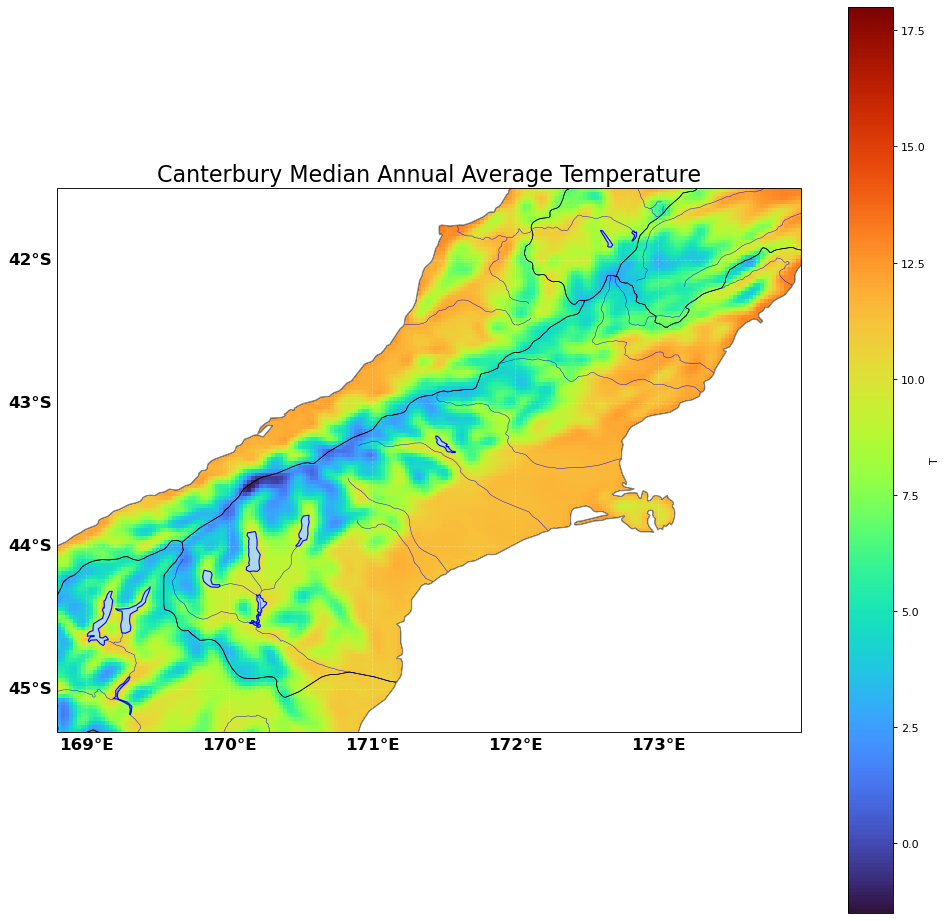

In [11]:
#calls the Projection_plt function with two arguments: Canterbury which is set to True and data which is set to median_annual_average_tem. This function plots a map of New Zealand or the Canterbury region, depending on the value of the Canterbury argument, and adds temperature data from median_annual_average_tem to the map.
Projection_plt(Canterbury = True, data = median_annual_average_tem)

## Task 4 Median annual total rainfall (20 Years)

In [4]:
import xarray as xr
import numpy as np
import salem
import cartopy.crs as ccrs
import glob
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask.array as da
import pandas as pd
from functools import partial
import seaborn as sns
import cartopy.feature as cfeature
import cartopy as cart
import matplotlib.ticker as mticker
import matplotlib.cm as cm

In [5]:
def yearly_RF_sum():
    """loads precipitation data from netCDF files, groups the data by year, and returns the yearly sum of precipitation. It uses xarray to open and manipulate the data, and dask to handle parallel computation. The function is designed to compute the yearly sum of precipitation from the MetService_WRF dataset."""
    # Load the dataset for rainfall accumulation files into the xarray object "ds_RF"
    ds_RF = xr.open_mfdataset("/mnt/data/MetService_WRF/RAINNC_*.nc", chunks={"time": 450}, parallel=True)
    
    # Extract the RAINNC variable from the xarray object and store it in a variable named "RF"
    RF = ds_RF.RAINNC
    
    # Group the RAINNC data by year
    year_grouped_RF = RF.groupby("time.year")
    
    # Sum the RAINNC data for each year along the time dimension and store it in a new variable named "yearly_RF_sum"
    yearly_RF_sum = year_grouped_RF.sum(dim = "time")
    
    # Compute the sum along the "time" dimension to release the memory, and return the yearly rainfall accumulation data
    return yearly_RF_sum.compute(dim = "time")

In [6]:
with ProgressBar():
    #calls the yearly_RF_sum() function and assigns its output to the variable yearly_RF_sum. The yearly_RF_sum() function calculates the yearly sum of rainfall data from a NetCDF file and returns the result.
    yearly_RF_sum = yearly_RF_sum()
yearly_RF_sum

[########################################] | 100% Completed | 22min 30.0s
[########################################] | 100% Completed |  2hr  1min  1.2s


<xarray.DataArray 'RAINNC' (year: 21, lat: 508, lon: 472)>
array([[[1295.7175 , 1287.8123 , 1292.3525 , ...,  644.03314,
          649.45605,  654.43616],
        [1285.9087 , 1289.3586 , 1301.3817 , ...,  641.2992 ,
          646.2596 ,  650.3059 ],
        [1290.5171 , 1309.8962 , 1331.1324 , ...,  635.1104 ,
          635.85486,  636.2637 ],
        ...,
        [1336.1161 , 1327.7878 , 1322.6165 , ..., 1045.4314 ,
         1069.5961 , 1090.187  ],
        [1312.6025 , 1340.2439 , 1359.6483 , ..., 1065.5284 ,
         1109.4698 , 1138.4769 ],
        [1320.934  , 1349.6223 , 1344.5725 , ..., 1161.8203 ,
         1145.7368 , 1140.707  ]],

       [[1319.7719 , 1323.667  , 1330.8192 , ...,  663.03937,
          661.699  ,  660.72253],
        [1301.2139 , 1312.8582 , 1324.8049 , ...,  671.25916,
          669.6796 ,  666.96967],
        [1307.8717 , 1321.9026 , 1336.4457 , ...,  655.25916,
          656.96216,  658.06104],
...
        [1181.979  , 1162.376  , 1130.0127 , ..., 1357.2042 ,
         1402.7722 , 1419.6858 ],
        [1171.3491 , 1139.5967 , 1121.6301 , ..., 1377.2797 ,
         1423.709  , 1443.8271 ],
        [1125.8258 , 1106.4441 , 1095.5267 , ..., 1422.5275 ,
         1456.9675 , 1453.1499 ]],

       [[1522.5586 , 1527.8744 , 1534.6302 , ...,  597.7696 ,
          597.0736 ,  601.72754],
        [1541.436  , 1542.893  , 1545.2843 , ...,  610.4695 ,
          609.37537,  609.0272 ],
        [1557.3015 , 1560.2675 , 1561.3257 , ...,  619.0433 ,
          618.47003,  617.2904 ],
        ...,
        [1468.9071 , 1468.1597 , 1425.4386 , ...,  839.79114,
          821.6097 ,  817.5503 ],
        [1458.8423 , 1457.3308 , 1419.3855 , ...,  849.9658 ,
          832.1082 ,  827.3711 ],
        [1482.193  , 1482.1726 , 1404.6399 , ...,  856.9939 ,
          843.7664 ,  855.2799 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020

In [121]:
#Computes the median of the yearly rainfall sum along the 'year' dimension of the xarray dataset 'yearly_RF_sum'
median_annual_sum_RF = yearly_RF_sum.median(dim="year")
median_annual_sum_RF

<xarray.DataArray 'RAINNC' (lat: 508, lon: 472)>
array([[1436.258  , 1447.1858 , 1438.5123 , ...,  744.1806 ,  743.7244 ,
         744.0575 ],
       [1453.2769 , 1455.832  , 1454.1493 , ...,  740.7987 ,  737.87854,
         735.77014],
       [1465.375  , 1464.8036 , 1460.2151 , ...,  730.0409 ,  725.76825,
         723.65186],
       ...,
       [1207.1326 , 1205.4384 , 1218.7684 , ..., 1242.6178 , 1257.7202 ,
        1219.6301 ],
       [1219.6067 , 1208.8849 , 1216.2927 , ..., 1252.8322 , 1217.0815 ,
        1228.0243 ],
       [1189.3739 , 1193.3478 , 1229.8391 , ..., 1233.8162 , 1233.0632 ,
        1244.4009 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0

In [83]:
def Projection_plt(Canterbury = True, data = median_annual_sum_RF):
    """generates a map of New Zealand or the Canterbury region, displaying the median annual average temperature. The function takes two parameters: Canterbury, which is a boolean value indicating whether the map should be zoomed in on the Canterbury region or not"""
    #Define a projection for this map
    map_proj = ccrs.PlateCarree()
    
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 15))
    
    # Set up the plot axes with the specified projection
    ax = plt.axes(projection=map_proj)
    
    # Add ocean areas to the map
    ax.add_feature(cart.OCEAN, zorder=2, edgecolor='grey', facecolor='white')
    
    # Zoom in to the Canterbury region if Canterbury=True, otherwise zoom out to show all of New Zealand
    if Canterbury == True:
        ax.set_extent([168.8, 174, -41.5, -45.3])
    else:
        ax.set_extent([164, 179, -34, -48])

    # set the aspect ratio of the map to "equal"
    ax.set_aspect('equal')
    
    # Add various features to the map
    ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='none', linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='grey', facecolor='white')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.4)
    
    # Draw spatial gridlines
    gls = ax.gridlines(draw_labels=True, color='white', alpha=0.2, linestyle='--')
    
    # change the spacing of the gridlines to every 5 degrees of longitude and latitude
    gls.xlocator = plt.FixedLocator(range(-180, 181, 1))
    gls.ylocator = plt.FixedLocator(range(-90, 91, 1))
    
    # change the font size and weight of the labels
    gls.xlabel_style = {'size': 15, 'weight': 'bold'}
    gls.ylabel_style = {'size': 15, 'weight': 'bold'}
    
    
    # hide the labels on the top and right edges of the map
    gls.top_labels = False
    gls.right_labels = False
    
    # If data is not specified, use the default value of median_annual_sum_RF
    data = median_annual_sum_RF
    
    # Plot the temperature data
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=400, vmax=9605, cmap="turbo_r")
    
    fig = plt.gcf()
    fig.set_dpi(80)
    
    # Add a title to the plot based on Canterbury was specified or not
    if Canterbury == True:
        plt.title('Canterbury Median Annual Total Rainfall', fontsize=20)
    else:
        plt.title('New Zealand Median Annual Total Rainfall', fontsize=20)
    
    # Display the plot
    plt.show()
    

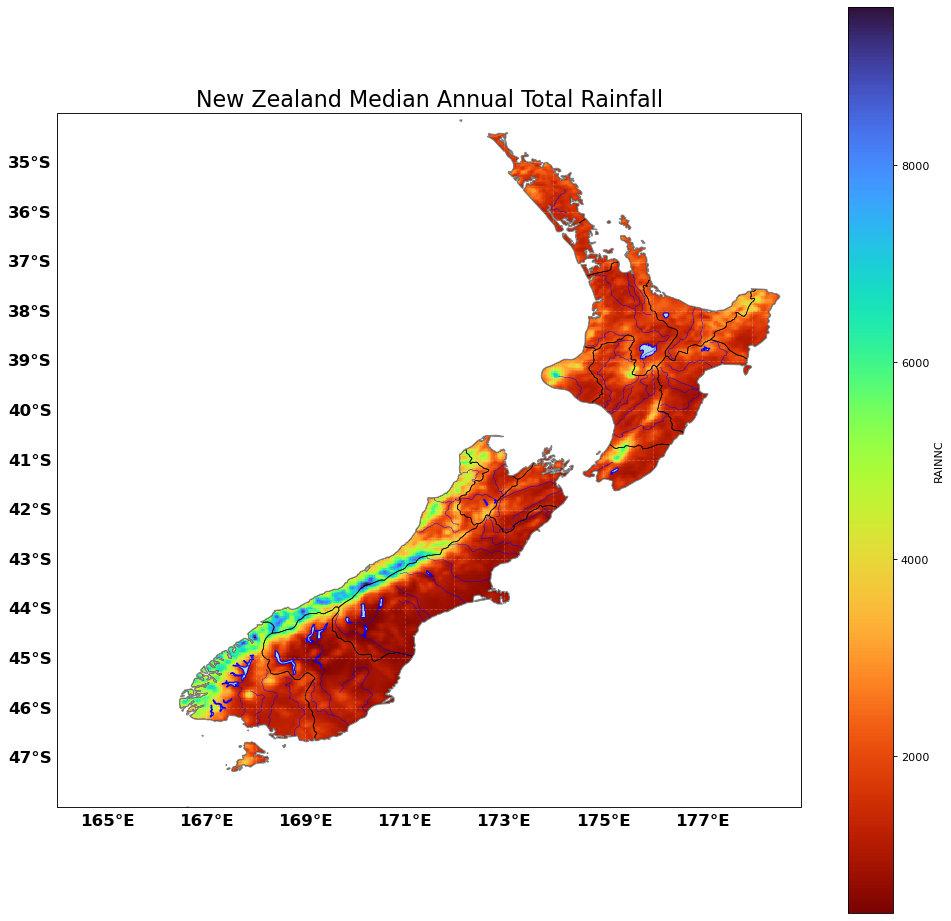

In [84]:
#calls the function Projection_plt() with two arguments: Canterbury is set to False and data is set to yearly_RF_sum. The Projection_plt() function will then be executed with these arguments.
Projection_plt(Canterbury = False, data = yearly_RF_sum)

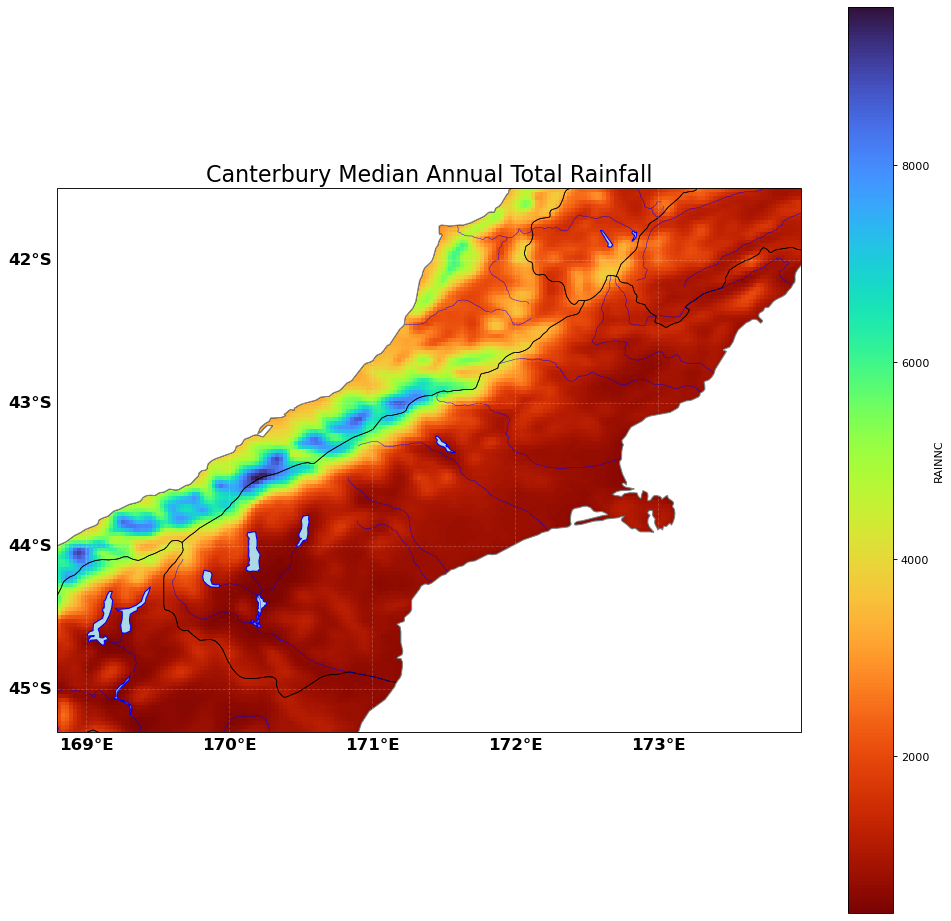

In [85]:
#calls the function Projection_plt and passes two arguments: Canterbury = True and data = yearly_RF_sum.
Projection_plt(Canterbury = True, data = yearly_RF_sum)